In [1]:
pip install sastrawi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [96]:
# Import libraries
import sys
import nltk
import re
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf
import joblib
from sklearn.metrics import classification_report 
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.layers import TextVectorization, Embedding, Dense, GlobalAveragePooling1D, Input, LSTM, GRU, Dropout, Conv1D, MaxPooling1D, GlobalMaxPooling1D, BatchNormalization
from tensorflow.keras.models import Model, Sequential, load_model
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from tensorflow.keras.utils import to_categorical
from imblearn.over_sampling import SMOTENC, SMOTE

tf.config.experimental_run_functions_eagerly(True)

# Download package dari nltk utk keperluan data preprocessing
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

# Set random seed supaya hasil simulasi tdk berubah-ubah
np.random.seed(50)
tf.random.set_seed(50)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [98]:
df = pd.read_excel('Dataset NLP Final edit.xlsx')

In [99]:
# Set lebar kolom menjadi 200
pd.set_option('display.max_colwidth',200)

In [100]:
df['Label'].value_counts()

neutral     429
positive    415
negative    126
Name: Label, dtype: int64

In [101]:
df.shape

(970, 6)

In [102]:
df.head()

,User,Date Created,Number of Likes,Source of Tweet,Tweet,Label
0,dodicccc,2018-07-01 00:00:00,0.0,Twitter for Android,"Jumat kemarin emiten emiten big caps (BBRI, BMRI, BBNI, BBCA, dll) yang bawa IHSG rebound.",positive
1,hedgeoption,2018-05-23 00:00:00,0.0,Twitter for iPhone,Big bank setelah turun gunung hr ini naik ke lembah #bbri #bbni #ihsg #saham #stockmarket #idx,negative
2,ftwijanarko,2018-03-23 00:00:00,0.0,Twitter for Android,@madedidu BBNI juga loh... Hiks.. :(,negative
3,ParulianRoby,2018-03-15 00:00:00,0.0,Twitter for Android,"#IDX #BEI #BBNI\n\nAndalan online, GoFood.\n.\nGelontorkan KUR Senilai 1,5 Triliun Rupiah untuk Merchant Go-Food, BNI Resmikan Kemitraan Strategis dengan Go-Pay.\n https://t.co/gF8X6zs6sC",positive
4,VenBanksInfo,2018-01-19 00:00:00,0.0,Twitter for iPhone,"Investment news;Finance sector IDR1,149.04 B(-0.24%)\nBBRI:IDR3,620(0.00%)\nBMRI:IDR8,075(-0.62%)\nBBNI:IDR9,425(-0.79%)\nBBCA:IDR22,450(-0.55%)",neutral


In [103]:
df.shape

(970, 6)

In [104]:
df['Label'] = df['Label'].replace(['positive', 'neutral', 'negative'], [0,1,2])

In [105]:
# Mendefinisikan stopwords bahasa Indonesia
idn = list(set(stopwords.words('indonesian')))

In [106]:
print(len(idn), "stopwords bahasa indonesia:", idn)

757 stopwords bahasa indonesia: ['sekecil', 'berjumlah', 'ialah', 'disebutkannya', 'terdapat', 'semisal', 'pun', 'diinginkan', 'terdahulu', 'dikatakan', 'pukul', 'masih', 'memang', 'lain', 'jumlah', 'besar', 'keterlaluan', 'persoalan', 'gunakan', 'dipergunakan', 'setiba', 'bersiap', 'sebenarnya', 'dijelaskan', 'sendirian', 'digunakan', 'dikira', 'diakhirinya', 'menunjuk', 'sela', 'jelaskan', 'sampai', 'setiap', 'ingin', 'tertuju', 'ingat', 'ia', 'tanya', 'pertama', 'dituturkannya', 'memperbuat', 'sekiranya', 'berapa', 'berkali-kali', 'bolehlah', 'keduanya', 'tepat', 'sampaikan', 'depan', 'mendapat', 'sangatlah', 'sebaik', 'pada', 'tersebut', 'jawaban', 'enggaknya', 'rupanya', 'tapi', 'dibuatnya', 'sudahlah', 'siapa', 'tiga', 'beginikah', 'benarkah', 'jikalau', 'berakhirlah', 'suatu', 'semuanya', 'asalkan', 'kedua', 'mampu', 'seringnya', 'punya', 'bukanlah', 'kemungkinan', 'melainkan', 'keinginan', 'terutama', 'melihatnya', 'kini', 'ke', 'kebetulan', 'memintakan', 'pak', 'ungkap', 'pent

In [107]:
factory = StemmerFactory()
stemmer = factory.create_stemmer()

In [108]:
# Membuat Sebuah Function Agar Dapat Diterapkan pada DataFrame

def text_process(text):
  # Mengubah Teks ke Lowercase
  text = text.lower()
  
  # Menghilangkan Mention
  text = re.sub("@[A-Za-z0-9_]+", " ", text)
  
  # Menghilangkan Hashtag
  text = re.sub("#[A-Za-z0-9_]+", " ", text)
  
  # Menghilangkan \n
  text = re.sub(r"\\n", " ",text)
  
  # Menghilangkan Whitespace
  text = text.strip()

  # Menghilangkan Link
  text = re.sub(r"http\S+", " ", text)
  text = re.sub(r"www.\S+", " ", text)

  # Menghilangkan yang Bukan Huruf seperti Emoji, Simbol Matematika (seperti μ), dst
  text = re.sub("[^A-Za-z\s']", " ", text)

  # Menghilangkan RT
  text = re.sub("rt", " ",text)

  # Melakukan Tokenisasi
  tokens = word_tokenize(text)

  # Menghilangkan Stopwords
  text = ' '.join([word for word in tokens if word not in idn])

  # Melakukan Stemming
  text = ' '.join([stemmer.stem(word) for word in text.split()])
  
  return text

In [109]:
df['Tweet_processed'] = df['Tweet'].apply(lambda x: text_process(x))

In [110]:
df

,User,Date Created,Number of Likes,Source of Tweet,Tweet,Label,Tweet_processed
0,dodicccc,2018-07-01 00:00:00,0.0,Twitter for Android,"Jumat kemarin emiten emiten big caps (BBRI, BMRI, BBNI, BBCA, dll) yang bawa IHSG rebound.",0,jumat kemarin emiten emiten big caps bbri bmri bbni bbca dll bawa ihsg rebound
1,hedgeoption,2018-05-23 00:00:00,0.0,Twitter for iPhone,Big bank setelah turun gunung hr ini naik ke lembah #bbri #bbni #ihsg #saham #stockmarket #idx,2,big bank turun gunung hr lembah
2,ftwijanarko,2018-03-23 00:00:00,0.0,Twitter for Android,@madedidu BBNI juga loh... Hiks.. :(,2,bbni loh hiks
3,ParulianRoby,2018-03-15 00:00:00,0.0,Twitter for Android,"#IDX #BEI #BBNI\n\nAndalan online, GoFood.\n.\nGelontorkan KUR Senilai 1,5 Triliun Rupiah untuk Merchant Go-Food, BNI Resmikan Kemitraan Strategis dengan Go-Pay.\n https://t.co/gF8X6zs6sC",0,andal online gofood gelontor kur nila triliun rupiah merchant go food bni resmi mitra strategis go pay
4,VenBanksInfo,2018-01-19 00:00:00,0.0,Twitter for iPhone,"Investment news;Finance sector IDR1,149.04 B(-0.24%)\nBBRI:IDR3,620(0.00%)\nBMRI:IDR8,075(-0.62%)\nBBNI:IDR9,425(-0.79%)\nBBCA:IDR22,450(-0.55%)",1,investment news finance sector idr b bbri idr bmri idr bbni idr bbca idr
...,...,...,...,...,...,...,...
965,NaN,2021-01-12 02:52:31+00:00,NaN,NaN,"@indopremier BMRI, BBTN, SMRA",1,bmri bbtn smra
966,NaN,2021-01-11 03:16:03+00:00,NaN,NaN,"#bbtn beli jumat ,jual senin,karena salah beli,untungnya beli panas McD doang..",1,beli jumat jual senin salah beli untung beli panas mcd doang
967,NaN,2021-01-06 04:08:29+00:00,NaN,NaN,@TradingDiary2 Ngikut $BBTN juga Pak,1,ngikut bbtn
968,NaN,2021-01-05 08:36:18+00:00,NaN,NaN,tertinggal oleh jejak BBCA nih 😉\n.\nWatchlist Perbankan versi #cuangasm @cuangasm 🤑\n1. BBNI\n2. BMRI\n3. BBTN\n.\nUntuk PGAS masih tahap wajar dan biasa 😊 walaupun tersandung kasus pajak dan aka...,2,te inggal jejak bbca nih watchlist perban versi bbni bmri bbtn pgas tahap wajar sandung pajak kena denda menteri runding tenang pgas


In [115]:
X = df['Tweet_processed']
y = df['Label']

In [19]:
#from imblearn.over_sampling import RandomOverSampler

In [18]:
#oversample = RandomOverSampler(sampling_strategy='minority')
# fit and apply the transform
#X_over, y_over = oversample.fit_resample(X, y)

In [116]:
# Lakukan train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2, # atur test set sebanyak 20%
                                                    random_state=101, 
                                                    stratify=df['Label']) # Lakukan stratify agar komposisi label dlm target sesauai

# Tampilkan ukuran train dan test set
print('Train Size : ', X_train.shape)
print('Test Size  : ', X_test.shape)

Train Size :  (776,)
Test Size  :  (194,)


In [117]:
# Definisikan TfidVectorizer ke dalam tf_idf_vect
tf_idf_vect = TfidfVectorizer()
X_train_vec = tf_idf_vect.fit(X_train) 
X_test_vec = tf_idf_vect.transform(X_test) # Transformasi X_test menggunakan vectorizer

In [118]:
# Tampilkan vocab
tf_idf_vect.get_feature_names_out()

array(['aaa', 'aali', 'aamin', ..., 'yusuf', 'yuuk', 'zuhur'],
      dtype=object)

In [119]:
# Mencari Jumlah Vocab dan Panjang Token dalam Satu DOcument

jml_vocab = len(tf_idf_vect.vocabulary_.keys())
max_sen_len = max([len(i.split(" ")) for i in X_train])

print("Jumlah vocab : ", jml_vocab)
print("Panjang maksimum kalimat : ", max_sen_len, "kata")

Jumlah vocab :  2387
Panjang maksimum kalimat :  41 kata


In [120]:
# Lakukan text vectorization

text_vectorization = TextVectorization(max_tokens=jml_vocab,
                                       standardize="lower_and_strip_punctuation",
                                       split="whitespace",
                                       ngrams=None,
                                       output_mode="int",
                                       output_sequence_length=max_sen_len,
                                       input_shape=(1,) # Jika ingin menggunakan Sequential API
                                       )

text_vectorization.adapt(X_train)

/usr/local/lib/python3.8/dist-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


In [121]:
# Embedding

embedding = Embedding(input_dim=jml_vocab,
                      output_dim=300,
                      input_length=max_sen_len
                      )

In [122]:
y_train_ohe = to_categorical(y_train)
y_test_ohe = to_categorical(y_test)

# LSTM

In [123]:
# Model definition dengan Menggunakan LSTM
model_lstm_2 = Sequential()
model_lstm_2.add(text_vectorization)
model_lstm_2.add(embedding)
model_lstm_2.add(Conv1D(80,8, activation="relu"))
model_lstm_2.add(MaxPooling1D(3))
model_lstm_2.add(Dropout(0.1))

model_lstm_2.add(LSTM(32,return_sequences=True))
model_lstm_2.add(Dropout(0.1))
#model_lstm_2.add(BatchNormalization())
model_lstm_2.add(LSTM(16))
model_lstm_2.add(Dropout(0.1))
#model_lstm_2.add(BatchNormalization())
model_lstm_2.add(Dense(3, activation='softmax'))

In [124]:
# Compile model
model_lstm_2.compile(loss='categorical_crossentropy',optimizer=tf.optimizers.Nadam(learning_rate=0.0001),metrics='accuracy')


In [126]:
# Training model
#hist_model_lstm_2 = model_lstm_2.fit(X_train,
hist_model_lstm_2 = model_lstm_2.fit(X_train,
                         y_train_ohe,
                         epochs=50,
                         validation_data=(X_test, y_test_ohe))

Epoch 1/50
25/25 [==============================] - 7s 269ms/step - loss: 1.0496 - accuracy: 0.4510 - val_loss: 1.0146 - val_accuracy: 0.4433
Epoch 2/50
25/25 [==============================] - 7s 282ms/step - loss: 1.0056 - accuracy: 0.4459 - val_loss: 0.9922 - val_accuracy: 0.4433
Epoch 3/50
25/25 [==============================] - 6s 241ms/step - loss: 0.9951 - accuracy: 0.4549 - val_loss: 0.9871 - val_accuracy: 0.4536
Epoch 4/50
25/25 [==============================] - 5s 221ms/step - loss: 0.9899 - accuracy: 0.4433 - val_loss: 0.9850 - val_accuracy: 0.4536
Epoch 5/50
25/25 [==============================] - 6s 227ms/step - loss: 0.9900 - accuracy: 0.4742 - val_loss: 0.9830 - val_accuracy: 0.4536
Epoch 6/50
25/25 [==============================] - 5s 218ms/step - loss: 0.9909 - accuracy: 0.4639 - val_loss: 0.9814 - val_accuracy: 0.5258
Epoch 7/50
25/25 [==============================] - 6s 224ms/step - loss: 0.9888 - accuracy: 0.4665 - val_loss: 0.9779 - val_accuracy: 0.4691
Epoch 

In [168]:
# Freeze trainable parameters
model_lstm_2.trainable = False
# Save model 
model_lstm_2.save('model_lstm.tf')

In [128]:
# Tampilkan history loss dan accuracy training dan validation set pada setiap epoch
metrics_model_lstm_hist_2 = pd.DataFrame(hist_model_lstm_2.history)
metrics_model_lstm_hist_2

,loss,accuracy,val_loss,val_accuracy
0,1.049601,0.451031,1.014596,0.443299
1,1.005622,0.445876,0.992185,0.443299
2,0.995072,0.454897,0.987111,0.453608
3,0.989929,0.443299,0.984984,0.453608
4,0.990008,0.474227,0.983010,0.453608
5,0.990905,0.463918,0.981394,0.525773
6,0.988827,0.466495,0.977853,0.469072
7,0.977798,0.524485,0.973729,0.530928
8,0.965268,0.554124,0.966033,0.525773
9,0.948129,0.600515,0.951769,0.525773


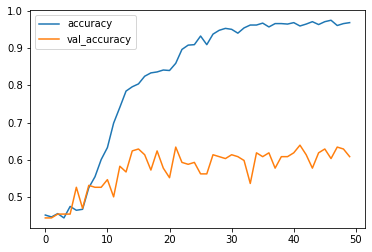

In [129]:
# Plot accuracy training dan validation set
metrics_model_lstm_hist_2[['accuracy', 'val_accuracy']].plot()

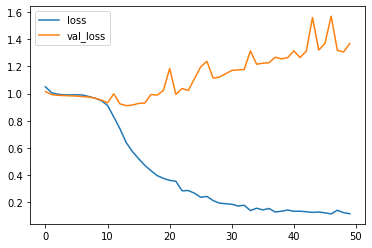

In [130]:
# Plot loss function training dan validation set
metrics_model_lstm_hist_2[['loss', 'val_loss']].plot()

In [131]:
y_pred_model_lstm_2 = np.argmax(model_lstm_2.predict(X_test), axis=-1)

2/7 [=======>......................] - ETA: 0s

/usr/local/lib/python3.8/dist-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


7/7 [==============================] - 0s 60ms/step


In [32]:
y_pred_model_lstm_2

array([1, 0, 1, 0, 2, 2, 2, 0, 0, 0, 2, 2, 1, 2, 1, 1, 1, 1, 1, 1, 2, 0,
       0, 0, 2, 0, 0, 2, 2, 2, 1, 0, 1, 0, 1, 2, 1, 1, 1, 0, 1, 1, 1, 2,
       2, 0, 2, 0, 2, 1, 1, 2, 2, 0, 2, 2, 1, 1, 1, 0, 1, 2, 1, 2, 2, 0,
       1, 0, 2, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 1, 0, 0, 2, 1, 0, 1, 0, 0, 2, 2, 0, 1, 1, 1, 2, 0, 0, 2, 1,
       0, 2, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 2, 2, 1, 1, 0, 1, 1, 0, 2,
       1, 1, 2, 0, 2, 0, 2, 0, 1, 2, 0, 1, 0, 0, 1, 2, 2, 1, 1, 2, 1, 1,
       0, 0, 1, 2, 0, 0, 1, 2, 0, 1, 2, 0, 0, 0, 0, 1, 0, 2, 2, 1, 2, 0,
       0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 2, 0, 0, 0, 1, 1, 2, 1, 0, 0, 0, 1,
       0, 0, 0, 2, 2, 1, 0, 1, 1, 0, 1, 0])

In [33]:
y_test

857    1
145    0
761    1
644    0
441    1
      ..
826    1
556    1
215    1
478    1
975    0
Name: Label, Length: 210, dtype: int64

In [132]:
print('Model Training Sendiri')
print(classification_report(y_test, y_pred_model_lstm_2))

Model Training Sendiri
              precision    recall  f1-score   support

           0       0.71      0.67      0.69        83
           1       0.86      0.50      0.63        86
           2       0.29      0.76      0.42        25

    accuracy                           0.61       194
   macro avg       0.62      0.64      0.58       194
weighted avg       0.72      0.61      0.63       194



In [169]:
!zip -r /content/model_lstm.zip /content/model_lstm.tf

  adding: content/model_lstm.tf/ (stored 0%)
  adding: content/model_lstm.tf/keras_metadata.pb (deflated 90%)
  adding: content/model_lstm.tf/saved_model.pb (deflated 89%)
  adding: content/model_lstm.tf/variables/ (stored 0%)
  adding: content/model_lstm.tf/variables/variables.index (deflated 63%)
  adding: content/model_lstm.tf/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: content/model_lstm.tf/assets/ (stored 0%)


In [21]:
import joblib
import sklearn
import tensorflow

In [23]:
print(joblib.__version__)


1.2.0


In [15]:
print(sklearn.__version__)

1.0.2


In [22]:
print(tensorflow.__version__)

2.9.2


In [24]:
!pip install joblib==1.1.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 309 kB 4.4 MB/s 
  Attempting uninstall: joblib
    Found existing installation: joblib 1.2.0
    Uninstalling joblib-1.2.0:
      Successfully uninstalled joblib-1.2.0


In [25]:
!pip install tensorflow==2.9.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 511.7 MB 20 kB/s 
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.9.2
    Uninstalling tensorflow-2.9.2:
      Successfully uninstalled tensorflow-2.9.2


In [5]:
df.to_excel('combine_df.xlsx')